In [2]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, GRU, BatchNormalization,
    Input, Flatten, Dropout, Activation,
    Conv1D, MaxPooling1D, AveragePooling1D
)

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical


2025-11-15 08:34:27.452433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763195667.645293      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763195667.697756      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.2 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,827 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/un

# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [4]:
#preparing data set
import os
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [5]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [6]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [7]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [8]:
import pandas as pd
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

/tmp/ipykernel_39/1422877610.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [9]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [10]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


**Integration**

In [12]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [13]:
print(data_path.Emotions.value_counts())


Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

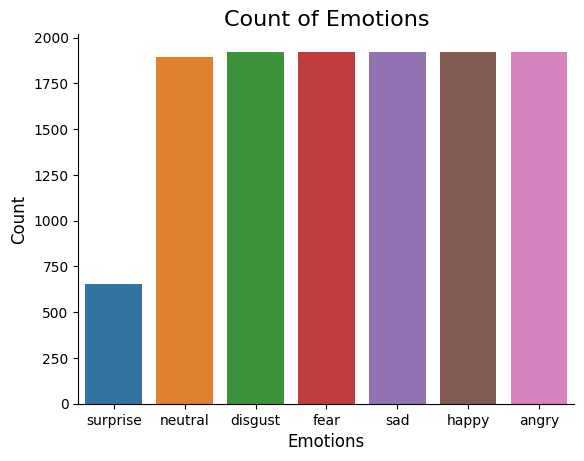

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)

sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [15]:
data,sr = librosa.load(file_path[0])
sr

22050

In [16]:
ipd.Audio(data,rate=sr)

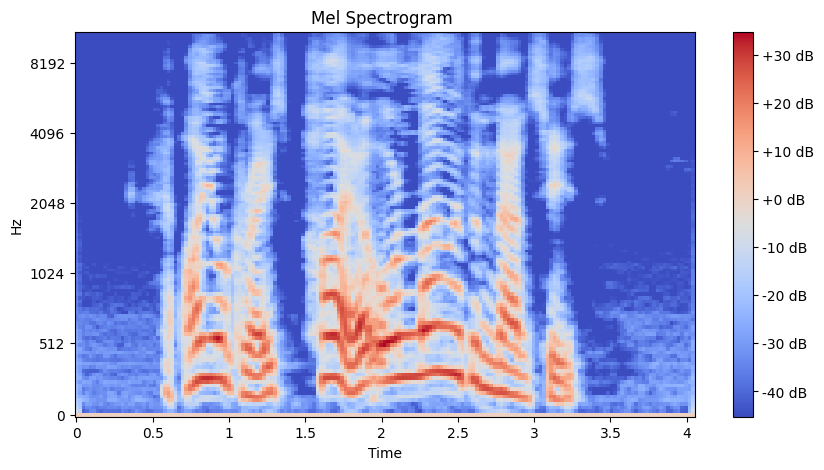

In [17]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

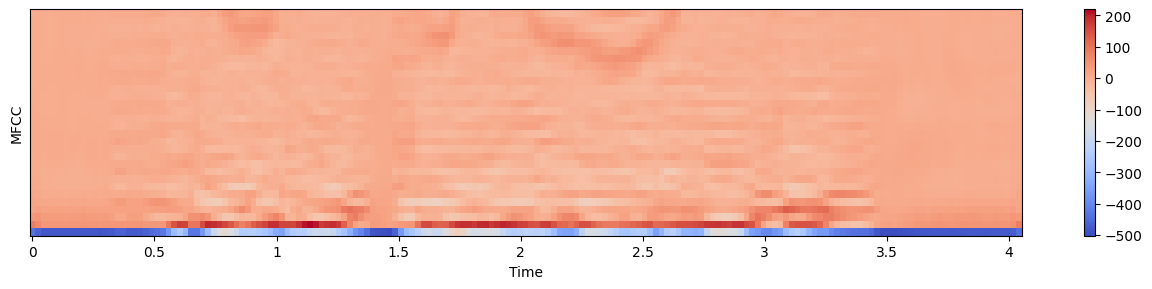

In [18]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [19]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

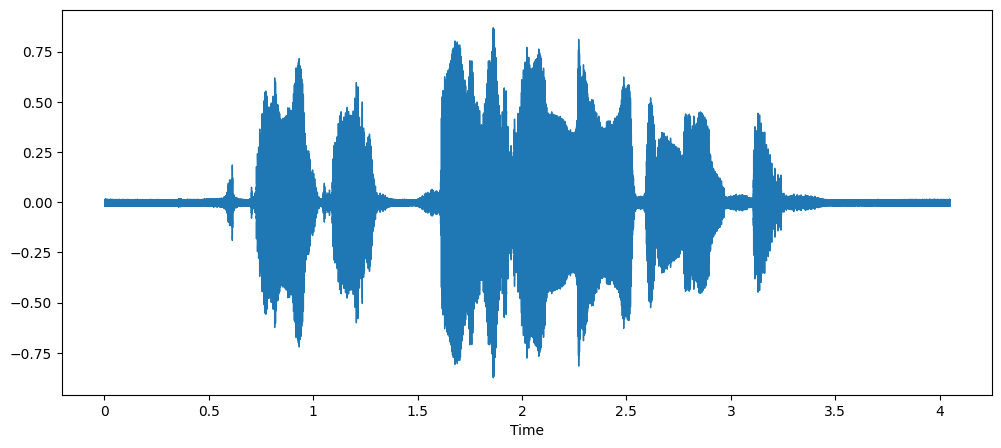

In [20]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

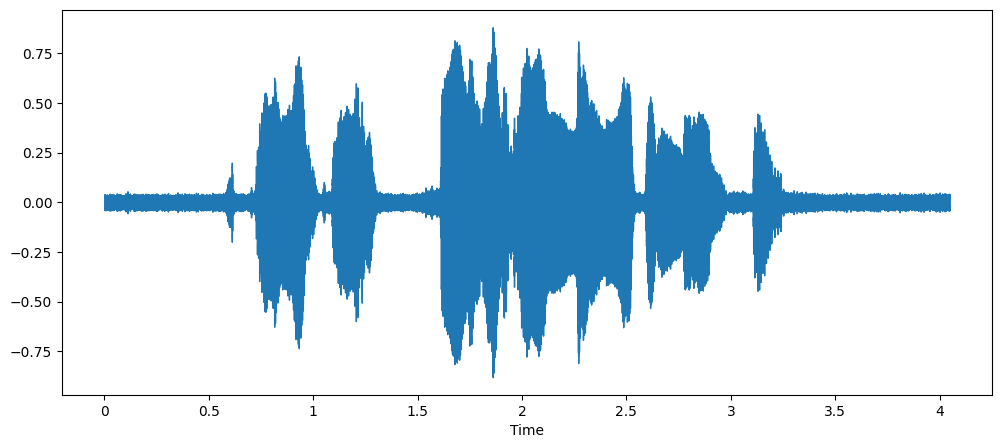

In [21]:
# AUDIO WITH NOISE
import numpy as np
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

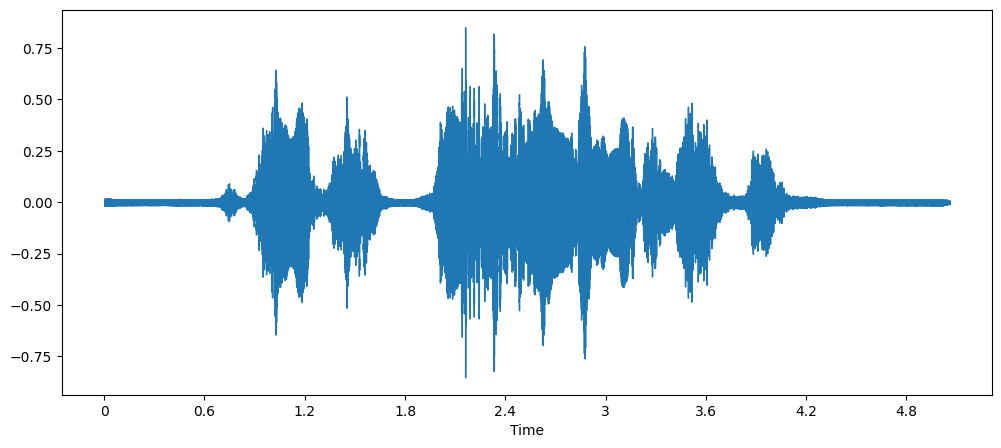

In [22]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

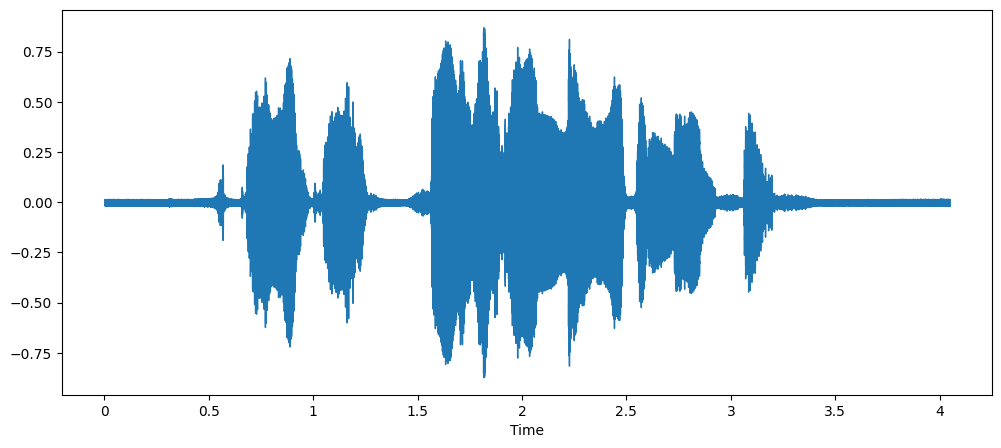

In [23]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

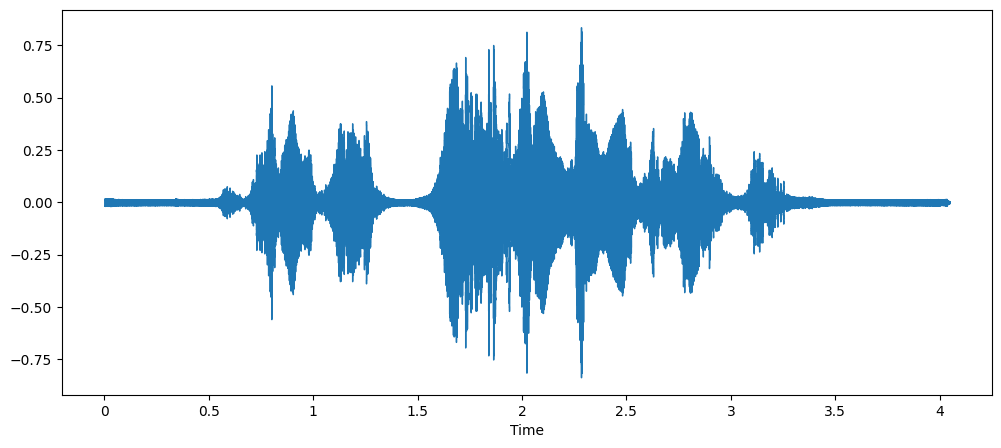

In [24]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [25]:

def zcr(data, frame_length=2048, hop_length=512):
    """Compute Zero Crossing Rate."""
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    """Compute Root Mean Square Energy."""
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr=22050, frame_length=2048, hop_length=512, flatten: bool=True):
    """Compute MFCCs."""
    mfcc_feat = librosa.feature.mfcc(
        y=data,
        sr=sr,
        n_mfcc=13,
        hop_length=hop_length,
        n_fft=frame_length
    )
    return np.squeeze(mfcc_feat.T) if not flatten else np.ravel(mfcc_feat.T)

# --- Combine all features ---

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    """Extract and concatenate all features."""
    result = np.hstack((
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    return result

# --- Main function for data augmentation and stacking ---

def get_features(path, duration=2.5, offset=0.6):
    """Load audio, extract features, and apply augmentations."""
    data, sr = librosa.load(path, duration=duration, offset=offset)
    
    # Original
    audio = extract_features(data, sr)
    
    # Apply augmentations (assumes you’ve defined these functions)
    noised_audio = noise(data)
    pitched_audio = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio)
    
    # Extract features for each
    audio_stack = np.vstack((
        audio,
        extract_features(noised_audio, sr),
        extract_features(pitched_audio, sr),
        extract_features(pitched_noised_audio, sr)
    ))
    
    return audio_stack

In [26]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


# Normal way to get features


In [27]:
# import timeit
# from tqdm import tqdm
# start = timeit.default_timer()
# X,Y=[],[]
# for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
#     features=get_features(path)
#     if index%500==0:
#         print(f'{index} audio has been processed')
#     for i in features:
#         X.append(i)
#         Y.append(emotion)
# print('Done')
# stop = timeit.default_timer()

# print('Time: ', stop - start)         

# Faster way to get features

In [28]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)   

Time:  372.094273458


In [29]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [30]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,9.226070,7.151148,5.051466,3.085228,1.378609,0.018686,-0.948774,-1.517691,-1.716481,surprise
1,0.256836,0.379883,0.510254,0.500000,0.492676,0.489746,0.477539,0.486328,0.491699,0.492188,...,-2.309492,-3.973836,-3.377150,-1.947305,1.943060,0.674677,-1.657314,-0.864835,-2.247096,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,4.590046,3.554258,2.544965,1.661706,0.983649,0.561133,0.411225,0.518303,0.838667,surprise
3,0.261719,0.380859,0.498535,0.465820,0.437500,0.409668,0.376953,0.367676,0.365234,0.365234,...,6.619938,-1.866736,-5.623429,-3.524039,-1.120533,-0.286776,-1.381963,-3.896114,4.874123,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,7.018448,4.313147,2.402374,1.351020,1.071218,1.380420,2.005288,2.586420,2.746858,neutral


In [31]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,9.226070,7.151148,5.051466,3.085228,1.378609,0.018686,-0.948774,-1.517691,-1.716481,surprise
1,0.256836,0.379883,0.510254,0.500000,0.492676,0.489746,0.477539,0.486328,0.491699,0.492188,...,-2.309492,-3.973836,-3.377150,-1.947305,1.943060,0.674677,-1.657314,-0.864835,-2.247096,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,4.590046,3.554258,2.544965,1.661706,0.983649,0.561133,0.411225,0.518303,0.838667,surprise
3,0.261719,0.380859,0.498535,0.465820,0.437500,0.409668,0.376953,0.367676,0.365234,0.365234,...,6.619938,-1.866736,-5.623429,-3.524039,-1.120533,-0.286776,-1.381963,-3.896114,4.874123,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,7.018448,4.313147,2.402374,1.351020,1.071218,1.380420,2.005288,2.586420,2.746858,neutral


In [32]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [33]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(48648, 1621)

In [34]:
np.sum(Emotions.isna())

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
1616        0
1617        0
1618        0
1619        0
Emotions    0
Length: 1621, dtype: int64

# Data preparation

In [35]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [36]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [37]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 1620)

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 7), (9730, 1620), (9730, 7))

In [39]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [40]:
# scaling our data with sklearn's Standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 1620), (38918, 7), (9730, 1620), (9730, 7))

In [41]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, GRU, BatchNormalization,
    Input, Flatten, Dropout, Activation,
    Conv1D, MaxPooling1D, AveragePooling1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


> Applying early stopping for all models


In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [43]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

In [44]:
model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

I0000 00:00:1763196210.486217      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1620, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1620, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1620, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1620, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1620, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1620, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1620, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,967 (3.27 MB)

 Trainable params: 856,967 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)

Epoch 1/20


I0000 00:00:1763196220.257628     843 cuda_dnn.cc:529] Loaded cuDNN version 90300


609/609 ━━━━━━━━━━━━━━━━━━━━ 384s 617ms/step - accuracy: 0.1730 - loss: 1.9013 - val_accuracy: 0.2073 - val_loss: 1.8875
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 374s 614ms/step - accuracy: 0.1833 - loss: 1.8927 - val_accuracy: 0.1906 - val_loss: 1.8821
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 374s 615ms/step - accuracy: 0.1918 - loss: 1.8814 - val_accuracy: 0.2025 - val_loss: 1.8664
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 367s 603ms/step - accuracy: 0.2008 - loss: 1.8756 - val_accuracy: 0.1601 - val_loss: 1.9066
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 366s 602ms/step - accuracy: 0.1635 - loss: 1.9039 - val_accuracy: 0.1959 - val_loss: 1.8972
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 366s 602ms/step - accuracy: 0.1826 - loss: 1.8936 - val_accuracy: 0.2199 - val_loss: 1.8618
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 366s 601ms/step - accuracy: 0.2044 - loss: 1.8677 - val_accuracy: 0.2406 - val_loss: 1.8308
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 366s 601ms/step - accuracy: 0.2335 - loss: 1.82

305/305 ━━━━━━━━━━━━━━━━━━━━ 79s 261ms/step - accuracy: 0.1552 - loss: 1.9032
Accuracy of our model on test data :  15.200410783290863 %


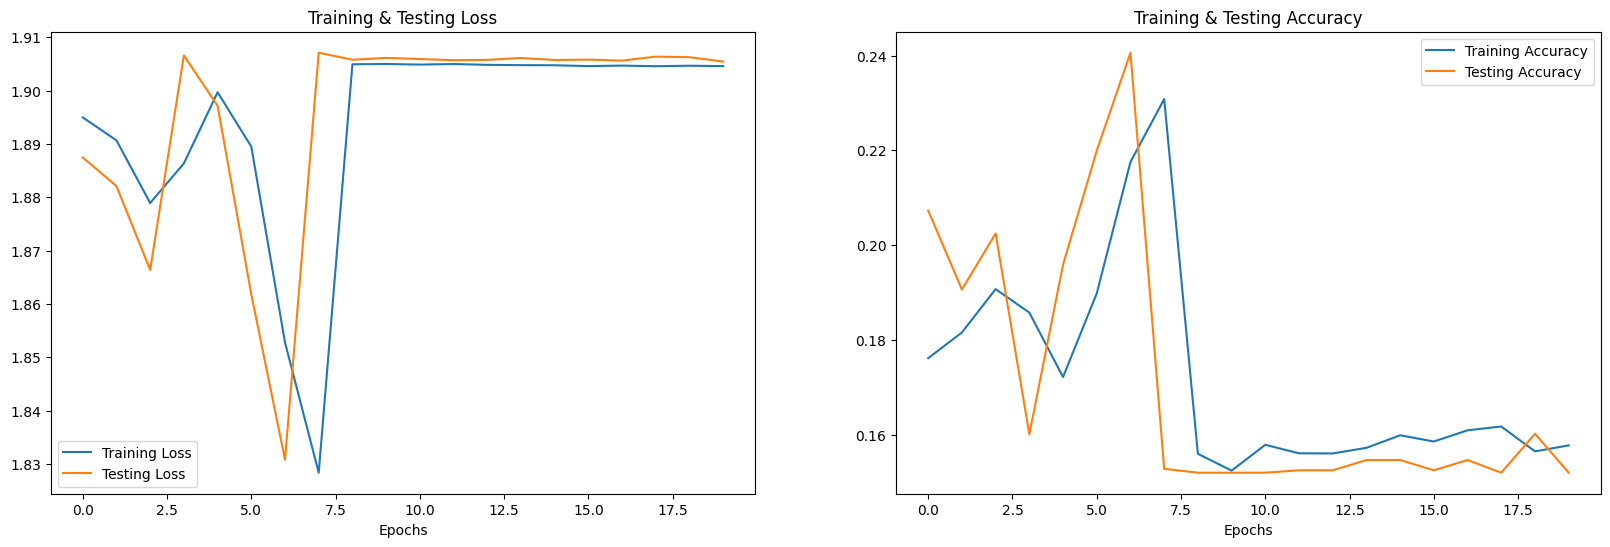

In [46]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# CNN model

In [47]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 1620, 1), (38918, 7), (9730, 1620, 1), (9730, 7))

In [48]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1620, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1620, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 810, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 810, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 810, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 405, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 405, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 203, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 203, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 102, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 102, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 102, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,59

 Total params: 5,620,359 (21.44 MB)

 Trainable params: 5,616,007 (21.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [49]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50


I0000 00:00:1763203656.500408     842 service.cc:148] XLA service 0x7f454389aa00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763203656.501211     842 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/609 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.1992 - loss: 2.7880   

I0000 00:00:1763203665.865390     842 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3940 - loss: 1.6707

E0000 00:00:1763203735.400698     843 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763203735.632933     843 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


609/609 ━━━━━━━━━━━━━━━━━━━━ 86s 116ms/step - accuracy: 0.3940 - loss: 1.6703 - val_accuracy: 0.3845 - val_loss: 1.6767 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.5199 - loss: 1.2388 - val_accuracy: 0.5199 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.5658 - loss: 1.1230 - val_accuracy: 0.5760 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.6040 - loss: 1.0205 - val_accuracy: 0.5491 - val_loss: 1.1744 - learning_rate: 0.0010
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.6425 - loss: 0.9245 - val_accuracy: 0.5988 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.6549 - loss: 0.9050 - val_accuracy: 0.5908 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.7170 - loss: 0.7519 - val_accuracy: 0.6803 - val_loss: 0.8704 - learning_rate: 0.0010
Epoch 8/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 61s 100ms/step - accuracy: 0.7534 - loss:

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9504 - loss: 0.1755
Accuracy of our model on test data :  95.33401727676392 %


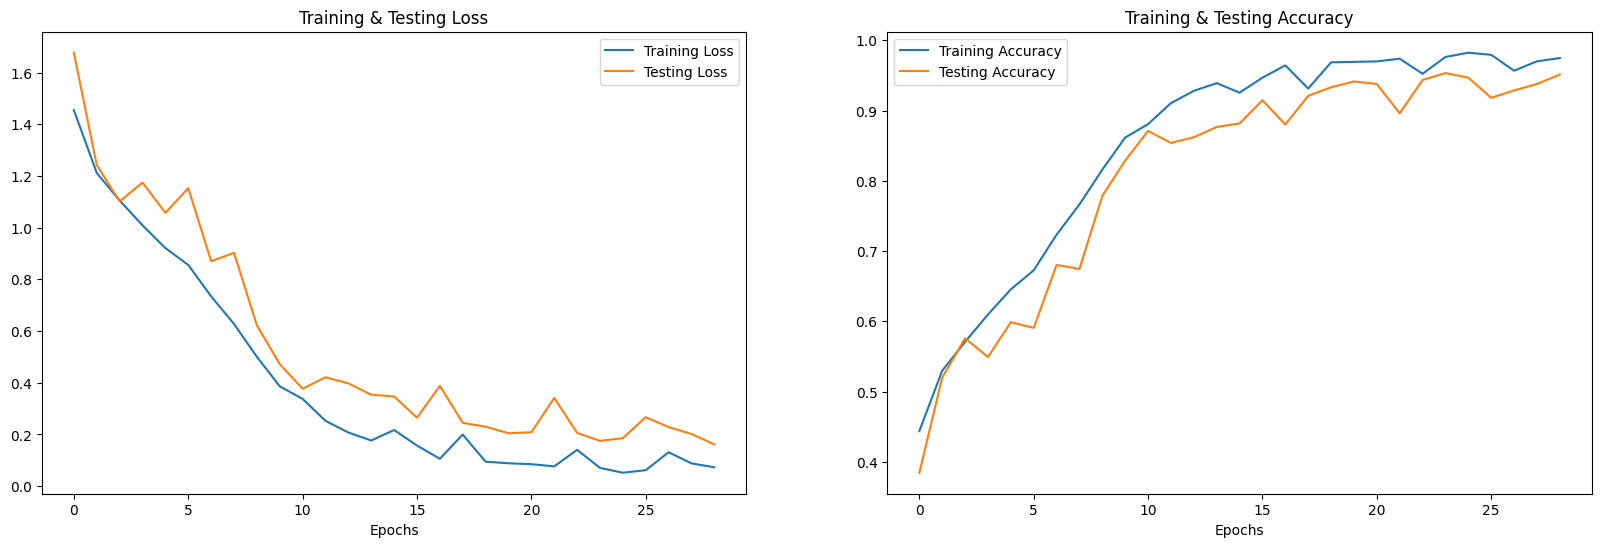

In [50]:
print("Accuracy of our model on test data : ", model.evaluate(x_testcnn, y_test)[1]*100, "%")

# Use actual number of epochs completed
epochs = range(len(history.history['accuracy']))

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Plot Loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plot Accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()


In [51]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [52]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


# CLSTM Model

In [53]:
#Build the model

# define model
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 1620, 1024)     │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 810, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 810, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 810, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 810, 512)       │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 405, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 405, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 405, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 203, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 203, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 203, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 203, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 203, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 203, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,778,247 (14.41 MB)

 Trainable params: 3,774,663 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

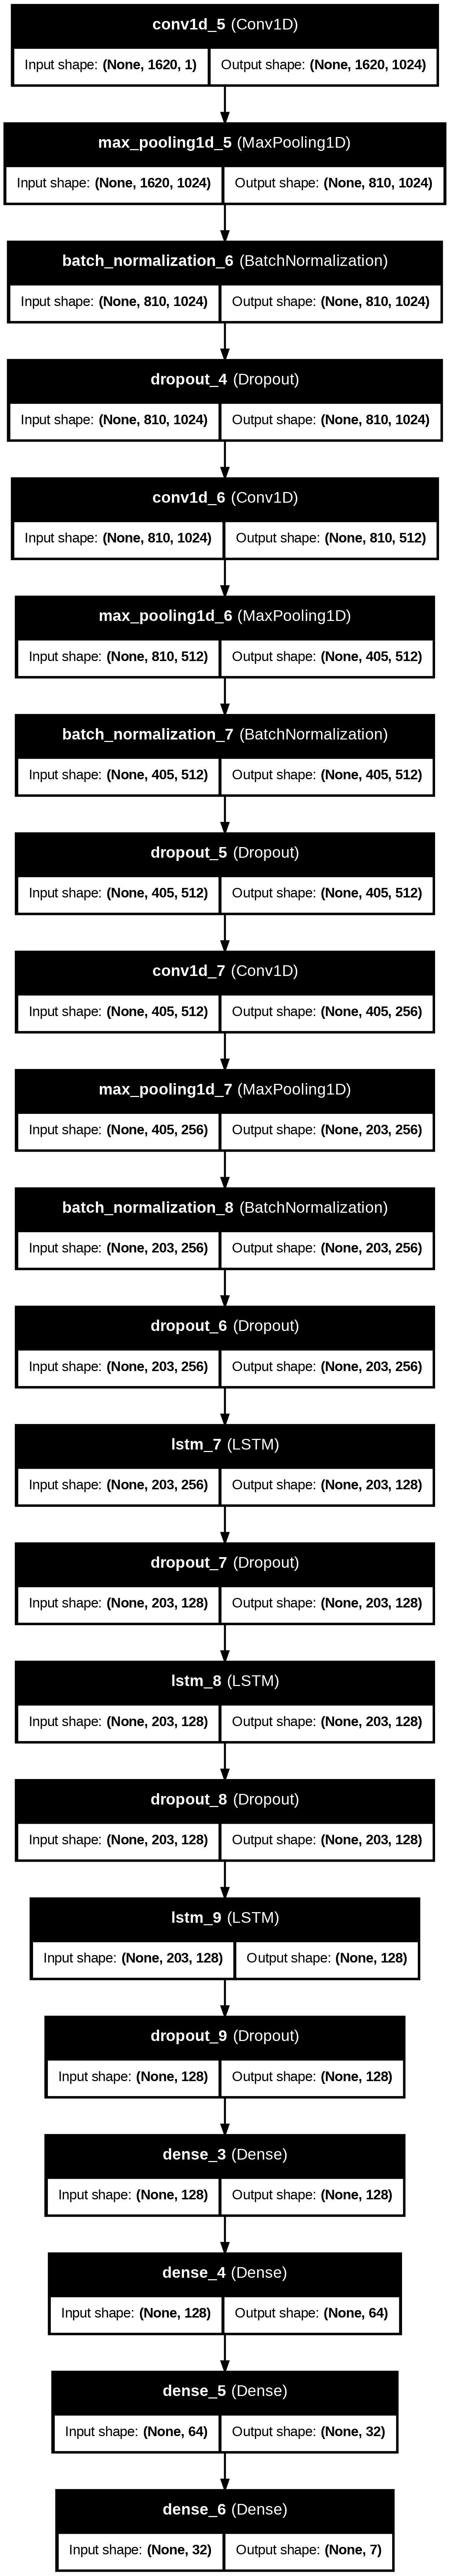

In [54]:
from tensorflow.keras.utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')

In [55]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=40, validation_data=(x_testcnn, y_test))

Epoch 1/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 140s 213ms/step - accuracy: 0.1947 - loss: 1.8769 - val_accuracy: 0.2565 - val_loss: 1.7839
Epoch 2/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.3096 - loss: 1.6804 - val_accuracy: 0.3338 - val_loss: 1.6168
Epoch 3/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 212ms/step - accuracy: 0.3631 - loss: 1.5813 - val_accuracy: 0.3806 - val_loss: 1.5599
Epoch 4/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.3974 - loss: 1.4866 - val_accuracy: 0.4180 - val_loss: 1.4198
Epoch 5/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.4253 - loss: 1.4282 - val_accuracy: 0.4227 - val_loss: 1.4245
Epoch 6/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.4349 - loss: 1.4021 - val_accuracy: 0.4551 - val_loss: 1.3474
Epoch 7/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.4570 - loss: 1.3580 - val_accuracy: 0.4496 - val_loss: 1.3685
Epoch 8/40
609/609 ━━━━━━━━━━━━━━━━━━━━ 129s 211ms/step - accuracy: 0.4709 -

305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6478 - loss: 0.9183
Accuracy of our model on test data :  64.8406982421875 %


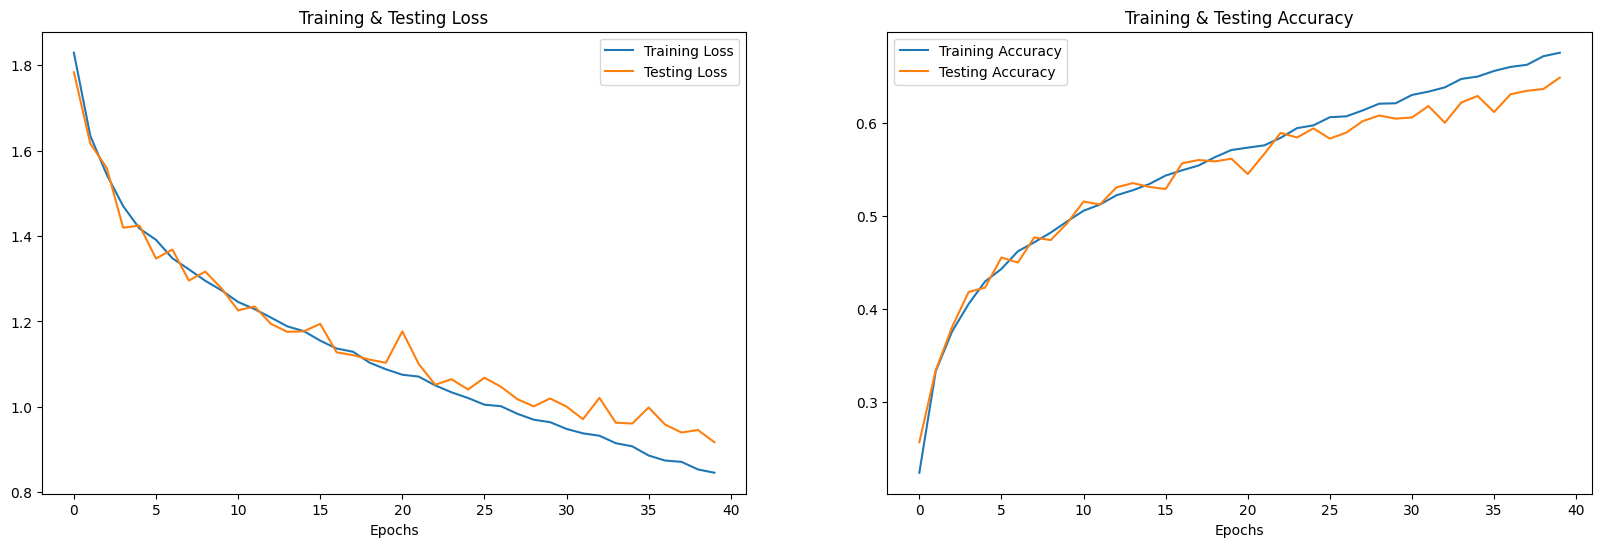

In [57]:
print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [58]:
# predicting on test data.
pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step


NameError: name 'pred_test' is not defined

# Evalutation

Results of best model

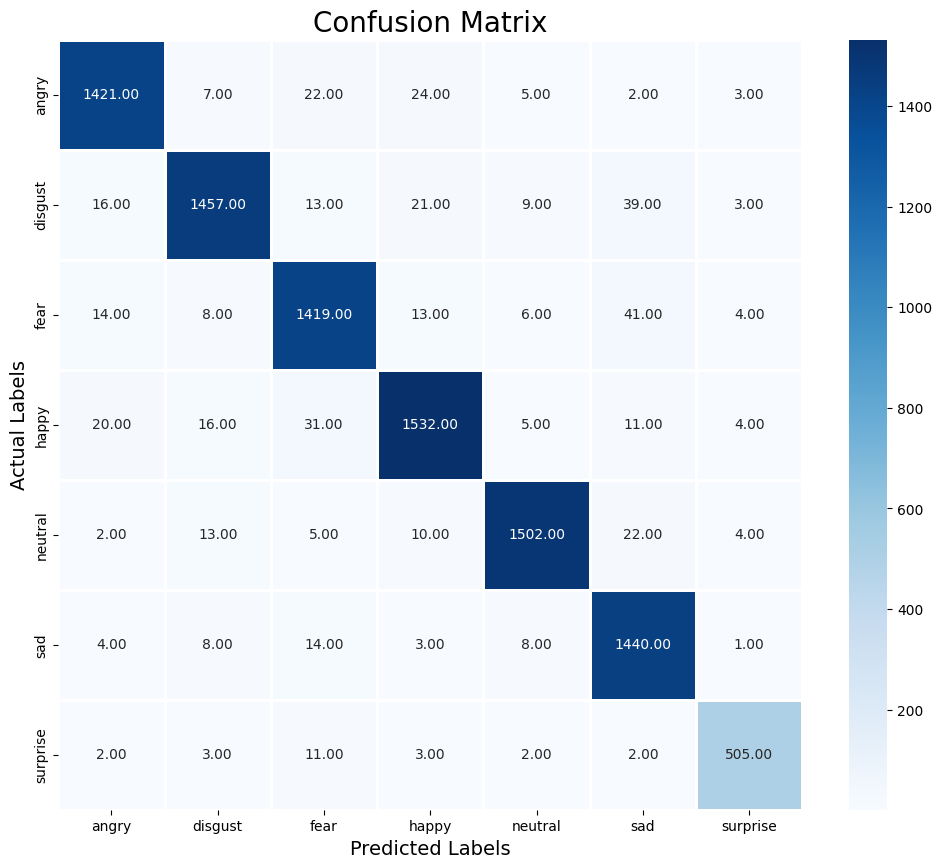

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96      1484
     disgust       0.96      0.94      0.95      1558
        fear       0.94      0.94      0.94      1505
       happy       0.95      0.95      0.95      1619
     neutral       0.98      0.96      0.97      1558
         sad       0.92      0.97      0.95      1478
    surprise       0.96      0.96      0.96       528

    accuracy                           0.95      9730
   macro avg       0.95      0.95      0.95      9730
weighted avg       0.95      0.95      0.95      9730



In [59]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [61]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk") 

Saved model to disk


In [62]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [63]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9504 - loss: 0.1755
compile_metrics: 95.33%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [64]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


# Test script
* That can predict new record 

In [65]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [66]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [67]:
import librosa

In [68]:
import numpy as np
import librosa


def zcr(data, frame_length=2048, hop_length=512):
    zcr_feat = librosa.feature.zero_crossing_rate(
        y=data, frame_length=frame_length, hop_length=hop_length
    )
    return np.squeeze(zcr_feat)


def rmse(data, frame_length=2048, hop_length=512):
    rmse_feat = librosa.feature.rms(
        y=data, frame_length=frame_length, hop_length=hop_length
    )
    return np.squeeze(rmse_feat)


def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_feat = librosa.feature.mfcc(
        y=data, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mfcc=13
    )
    # Flatten across time so each audio gives a long feature vector
    return np.ravel(mfcc_feat.T) if flatten else np.squeeze(mfcc_feat.T)


def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    
    result = np.hstack((
        result,
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    
    return result

def load_fixed_audio(path, sr=22050, duration=2.0):
    target_length = int(sr * duration)
    data, _ = librosa.load(path, sr=sr)
    if len(data) > target_length:
        data = data[:target_length]  # Trim longer files
    else:
        data = np.pad(data, (0, target_length - len(data)), mode='constant')  # Pad shorter ones
    return data




In [69]:
def get_predict_feat(path):
    d, sr = librosa.load(path, sr=22050)
    res = extract_features(d, sr)
    result = np.array(res)

    # 🔧 Force feature vector to match training dimension
    target_len = 1620
    if result.shape[0] > target_len:
        result = result[:target_len]
    elif result.shape[0] < target_len:
        result = np.pad(result, (0, target_len - result.shape[0]), mode='constant')

    result = result.reshape(1, -1)
    i_result = scaler2.transform(result)
    final_result = np.expand_dims(i_result, axis=2)
    return final_result


In [70]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 1620, 1)


In [71]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [72]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

E0000 00:00:1763210742.595785     843 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763210742.825308     843 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
happy


In [73]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
happy


In [74]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
angry


In [75]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
happy


In [76]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
disgust


In [77]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
disgust


In [78]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
disgust
